# Setup Dataset

In [1]:
import os
import gc
import time
import copy
import matplotlib.pyplot as plt


import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import defaultdict, Counter


import torch 
import torchvision
import torch.nn as nn
import torch.optim as pt_optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models.densenet import DenseNet
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchvision.datasets.folder import DatasetFolder
from torchvision.models import resnet50, resnet152, resnet18
from torchsummary import summary

In [2]:
import os

try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  from google.colab import drive
  drive.mount('/content/drive')
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  model_save_folder = os.path.join(data_filepath, "gravitational-lensing", "Task1", "models")
  os.makedirs(model_save_folder, exist_ok=True)

else:
  data_filepath = "data"
     

Mounted at /content/drive


In [3]:
!ls /content/drive

MyDrive


In [4]:
!cp /content/drive/MyDrive/datasets/ML4SCI_GSOC23/gravitational-lensing/Task1/dataset.zip .
!unzip -q dataset.zip

In [5]:
!ls /content/drive/MyDrive/datasets/ML4SCI_GSOC23/

gravitational-lensing
models
QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet
QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet
SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Task2
tensorboard


In [6]:
import os

def getFilenamesFullPath(path):
  no_path = os.path.join(*path)
  no = os.listdir(no_path)
  return sorted([os.path.join(no_path, v) for v in no])

dataset_filepath_train = os.path.join("dataset", "train")
dataset_filepath_val = os.path.join("dataset", "val")

print(os.listdir(dataset_filepath_train))

no = getFilenamesFullPath(["dataset", "train", "no"])
vort = getFilenamesFullPath(["dataset", "train", "vort"])
sphere = getFilenamesFullPath(["dataset", "train", "sphere"])

print(f"size of no class : {len(no)}")
print(f"size of vort class : {len(vort)}")
print(f"size of sphere class : {len(sphere)}")

['.DS_Store', 'vort', 'sphere', 'no']
size of no class : 10000
size of vort class : 10000
size of sphere class : 10000


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

mean = 0.485
std = 0.229

mean = 0.06169275318411914
std = 0.1172684106873827
batch_size = 64

_transforms = transforms.Compose([
    torchvision.transforms.Normalize((mean), (std))
])

def load_npy(path : str) -> torch.Tensor:
    # load the image
    img = torch.from_numpy(np.load(path))

    # preprocess it     
    return _transforms(img)

train_ds = DatasetFolder(dataset_filepath_train, extensions=[".npy"], loader=load_npy)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = DatasetFolder(dataset_filepath_val, extensions=[".npy"], loader=load_npy)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

Device Used : cuda:0


# Pytorch utils

In [8]:
def evaluate_model(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = nn.CrossEntropyLoss()

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = torch.cat([inputs,inputs,inputs],1)
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)
            
            #print(outputs.shape)
            loss = criterion(outputs, labels)

            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  
    
    time_elapsed = time.time() - since
    print(f'VALIDATION : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since, 2)}')
    return {"loss" : epoch_loss, "accuracy" : epoch_acc.item(), "AUC_ROC" : AUC_ROC}

In [9]:
def evaluate_model(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = nn.CrossEntropyLoss()

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = torch.cat([inputs,inputs,inputs],1)
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)
            
            #print(outputs.shape)
            loss = criterion(outputs, labels)

            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  
    
    time_elapsed = time.time() - since
    print(f'VALIDATION : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since, 2)}')
    return {"loss" : epoch_loss, "accuracy" : epoch_acc.item(), "AUC_ROC" : AUC_ROC}

In [10]:
def training_epoch(model, optimizer, scheduler, 
                   train_dataloader, train_dataset_size,
                   valid_dataloader, valid_dataset_size, 
                   num_epochs=25, update_every=5,
                   clean_every = 10,
                   save_path=os.path.join(model_save_folder, 'model_AUC={}.pth')):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : [],
                  "validationLoss" : [], "validationAccuracy" : [], "validationAUC" : []}
    best_model_wts = copy.deepcopy(model)
    best_AUC_score = 0
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()
        criterion = nn.CrossEntropyLoss()

        i = 0
        samples_so_far = 0
        # Iterate over data.
        progress_bar = tqdm(train_dataloader)
        for inputs, labels in progress_bar:
            i += 1
            samples_so_far += inputs.shape[0]
            inputs = torch.cat([inputs,inputs,inputs],1)
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs).softmax(dim=1)
                probs, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % update_every == 0:
                rl_avg = running_loss / samples_so_far
                acc_avg = running_corrects / samples_so_far
                AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

                progress_bar.set_description(f"loss = {rl_avg}, accuracy : {acc_avg}, AUC ROC {AUC_ROC}")
            
            if clean_every != -1 and i % clean_every == 0:
                gc.collect()
            scheduler.step()

        epoch_loss = running_loss / train_dataset_size
        epoch_acc = running_corrects.double() / train_dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'TRAINING ; Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        eval_result = evaluate_model(model, valid_dataloader, valid_dataset_size)

        returnDict["validationLoss"].append(eval_result["loss"])
        returnDict["validationAccuracy"].append(eval_result["accuracy"])
        returnDict["validationAUC"].append(eval_result["AUC_ROC"])
        if eval_result["AUC_ROC"] > best_AUC_score:
          torch.save(model, save_path.format(round(eval_result["AUC_ROC"], 3)))
          best_AUC_score = eval_result["AUC_ROC"]
          model_best = copy.deepcopy(model)
          print("New best, saving !")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model_best
    return returnDict

In [11]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.legend()

    plt.show()


In [12]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, _summary=True, 
                 input_size=(3,32,32), model_name="model_AUC={}.pth"):
  global train_dl, train_ds, val_dl, val_ds
  if _summary:
    print(summary(model_ft, input_size=input_size, device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=3e-5)
  lr_sched = pt_lr_scheduler.CyclicLR(optim, learning_rate, 5 * learning_rate, step_size_up=round(len(train_ds) / batch_size), cycle_momentum=False)

  dats = training_epoch(model_ft, optim, lr_sched, 
                        train_dl,  len(train_ds) , 
                        val_dl, len(val_ds),
                        num_epochs=epochs,
                        save_path=os.path.join(model_save_folder, model_name))
  
  if plot:
    plotResults(dats)
  return dats

In [13]:
# dealing with multiclass and still want 
def get_fpr_tpr_auc_forModel(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = nn.CrossEntropyLoss()

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = torch.cat([inputs,inputs,inputs],1)
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)
            
            #print(outputs.shape)
            loss = criterion(outputs, labels)

            pred_y = torch.cat([pred_y, outputs.cpu()])
    
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)


    true_y = y.detach().numpy()
    pred_probs = F.softmax(pred_y, dim=1).detach().numpy()
    AUC_ROC = roc_auc_score(true_y, pred_probs , multi_class="ovr")  
    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len

    print(f"epoch loss : {epoch_loss} , acc : {epoch_acc}, AUC : {AUC_ROC}")

    # Binarize the true labels
    true_labels = label_binarize(true_y, classes=list(range(3)))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], np.array(pred_probs)[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), np.array(pred_probs).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= 3

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr


    time_elapsed = time.time() - since
    return {"AUC" : AUC_ROC, "FPR" : fpr["macro"], "TPR" : tpr["macro"]}

In [14]:
def plot_ROC_curve_for_models(models, label="ROC curve for model"):
  c = get_fpr_tpr_auc_forModel(models, val_dl, len(val_ds))
  plt.figure(figsize=(12, 12))
  plt.title(f"AUC  ROC : {c['AUC']}")
  plt.plot([0.0] + list(c["FPR"]), [0.0] + list(c["TPR"]), label=label)
  plt.plot([0.0, 1.0], [0.0, 1.0], label="random")
  plt.legend()
  plt.show()

# Resnet 18

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

loss = 1.013426910805446, accuracy : 0.4921035170555115, AUC ROC 0.6870736321550824: 100%|██████████| 469/469 [01:26<00:00,  5.44it/s]


TRAINING ; Loss: 1.0130 Acc: 0.4927 AUC ROC : 0.6876 Time taken : 86.24


100%|██████████| 118/118 [00:09<00:00, 12.44it/s]


VALIDATION : Loss: 8.4952 Acc: 0.3883 AUC ROC : 0.6588 Time taken : 9.5
New best, saving !
Epoch 1/14
----------


loss = 0.8306775936516383, accuracy : 0.7097110152244568, AUC ROC 0.8632206540120175: 100%|██████████| 469/469 [01:15<00:00,  6.20it/s]


TRAINING ; Loss: 0.8298 Acc: 0.7106 AUC ROC : 0.8639 Time taken : 75.71


100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


VALIDATION : Loss: 0.8992 Acc: 0.8211 AUC ROC : 0.9385 Time taken : 8.6
New best, saving !
Epoch 2/14
----------


loss = 0.7613278563304614, accuracy : 0.782963752746582, AUC ROC 0.9123909675543812: 100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


TRAINING ; Loss: 0.7615 Acc: 0.7828 AUC ROC : 0.9122 Time taken : 74.89


100%|██████████| 118/118 [00:09<00:00, 13.08it/s]


VALIDATION : Loss: 0.9802 Acc: 0.7323 AUC ROC : 0.8980 Time taken : 9.03
Epoch 3/14
----------


loss = 0.7322793759325499, accuracy : 0.8136425018310547, AUC ROC 0.9305913163031011: 100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


TRAINING ; Loss: 0.7318 Acc: 0.8141 AUC ROC : 0.9309 Time taken : 75.01


100%|██████████| 118/118 [00:09<00:00, 13.06it/s]


VALIDATION : Loss: 0.7330 Acc: 0.8631 AUC ROC : 0.9606 Time taken : 9.05
New best, saving !
Epoch 4/14
----------


loss = 0.7059279572579169, accuracy : 0.8418682813644409, AUC ROC 0.9463635977050658: 100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


TRAINING ; Loss: 0.7063 Acc: 0.8415 AUC ROC : 0.9461 Time taken : 74.65


100%|██████████| 118/118 [00:08<00:00, 13.88it/s]


VALIDATION : Loss: 1.0900 Acc: 0.8152 AUC ROC : 0.9375 Time taken : 8.51
Epoch 5/14
----------


loss = 0.704212438291119, accuracy : 0.8425739407539368, AUC ROC 0.9475839837070973: 100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


TRAINING ; Loss: 0.7040 Acc: 0.8428 AUC ROC : 0.9477 Time taken : 74.7


100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


VALIDATION : Loss: 0.5784 Acc: 0.8809 AUC ROC : 0.9693 Time taken : 8.54
New best, saving !
Epoch 6/14
----------


loss = 0.6878594948399451, accuracy : 0.8595766425132751, AUC ROC 0.9561184078029302: 100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


TRAINING ; Loss: 0.6880 Acc: 0.8595 AUC ROC : 0.9560 Time taken : 74.77


100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


VALIDATION : Loss: 1.0781 Acc: 0.7655 AUC ROC : 0.9154 Time taken : 8.65
Epoch 7/14
----------


loss = 0.6872164826239309, accuracy : 0.8613239526748657, AUC ROC 0.9564759845202208: 100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


TRAINING ; Loss: 0.6870 Acc: 0.8616 AUC ROC : 0.9566 Time taken : 74.91


100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


VALIDATION : Loss: 0.5709 Acc: 0.8932 AUC ROC : 0.9722 Time taken : 8.69
New best, saving !
Epoch 8/14
----------


loss = 0.6743092794572153, accuracy : 0.8747648000717163, AUC ROC 0.9613151682863442: 100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


TRAINING ; Loss: 0.6745 Acc: 0.8745 AUC ROC : 0.9611 Time taken : 74.92


100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


VALIDATION : Loss: 1.1299 Acc: 0.8364 AUC ROC : 0.9500 Time taken : 8.66
Epoch 9/14
----------


loss = 0.6788521678216995, accuracy : 0.8698253035545349, AUC ROC 0.9601452291860503: 100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


TRAINING ; Loss: 0.6787 Acc: 0.8700 AUC ROC : 0.9602 Time taken : 74.76


100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


VALIDATION : Loss: 0.5478 Acc: 0.8897 AUC ROC : 0.9732 Time taken : 8.57
New best, saving !
Epoch 10/14
----------


loss = 0.6627760255208579, accuracy : 0.886424720287323, AUC ROC 0.967084277718754: 100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


TRAINING ; Loss: 0.6628 Acc: 0.8864 AUC ROC : 0.9670 Time taken : 74.66


100%|██████████| 118/118 [00:08<00:00, 13.81it/s]


VALIDATION : Loss: 0.8678 Acc: 0.8447 AUC ROC : 0.9473 Time taken : 8.56
Epoch 11/14
----------


loss = 0.6702222445959686, accuracy : 0.8784274458885193, AUC ROC 0.9637571836417762: 100%|██████████| 469/469 [01:14<00:00,  6.30it/s]


TRAINING ; Loss: 0.6699 Acc: 0.8787 AUC ROC : 0.9639 Time taken : 74.47


100%|██████████| 118/118 [00:08<00:00, 13.95it/s]


VALIDATION : Loss: 0.5474 Acc: 0.8960 AUC ROC : 0.9742 Time taken : 8.47
New best, saving !
Epoch 12/14
----------


loss = 0.6583900679824173, accuracy : 0.8902890086174011, AUC ROC 0.9693156834683748: 100%|██████████| 469/469 [01:14<00:00,  6.33it/s]


TRAINING ; Loss: 0.6589 Acc: 0.8897 AUC ROC : 0.9692 Time taken : 74.13


100%|██████████| 118/118 [00:08<00:00, 13.90it/s]


VALIDATION : Loss: 1.0387 Acc: 0.8136 AUC ROC : 0.9354 Time taken : 8.5
Epoch 13/14
----------


loss = 0.6596339553915044, accuracy : 0.8902217745780945, AUC ROC 0.9680576212060501: 100%|██████████| 469/469 [01:13<00:00,  6.35it/s]


TRAINING ; Loss: 0.6594 Acc: 0.8905 AUC ROC : 0.9682 Time taken : 73.91


100%|██████████| 118/118 [00:08<00:00, 13.86it/s]


VALIDATION : Loss: 0.5202 Acc: 0.9052 AUC ROC : 0.9771 Time taken : 8.53
New best, saving !
Epoch 14/14
----------


loss = 0.6519889493142405, accuracy : 0.8975470662117004, AUC ROC 0.9712949167691537: 100%|██████████| 469/469 [01:13<00:00,  6.35it/s]


TRAINING ; Loss: 0.6522 Acc: 0.8973 AUC ROC : 0.9712 Time taken : 73.96


100%|██████████| 118/118 [00:08<00:00, 14.12it/s]


VALIDATION : Loss: 1.0673 Acc: 0.8525 AUC ROC : 0.9575 Time taken : 8.37
Training complete in 21m 3s


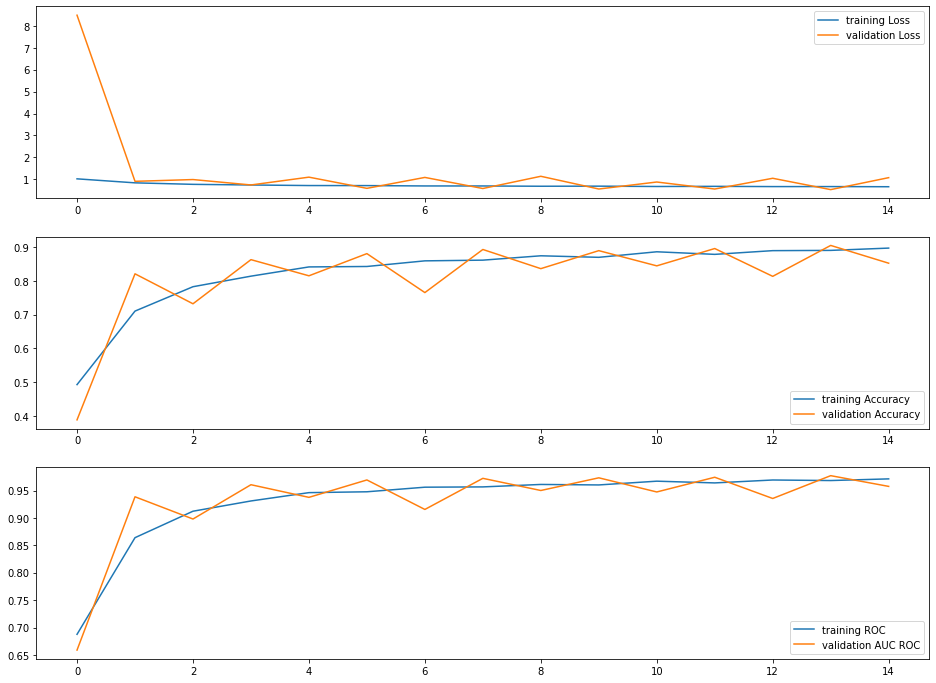

In [15]:
model = resnet18(True)
model.fc = torch.nn.Linear(512,3)
resnet18_experiment_results = doExperiment(model, epochs=15, learning_rate=3e-4, input_size=(3, 125, 125),
                                           model_name="resnet18_pretrained_AUC={}.pth")

## AUC ROC curve

100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


epoch loss : 0.5201576435565949 , acc : 0.9052, AUC : 0.9770850533333334


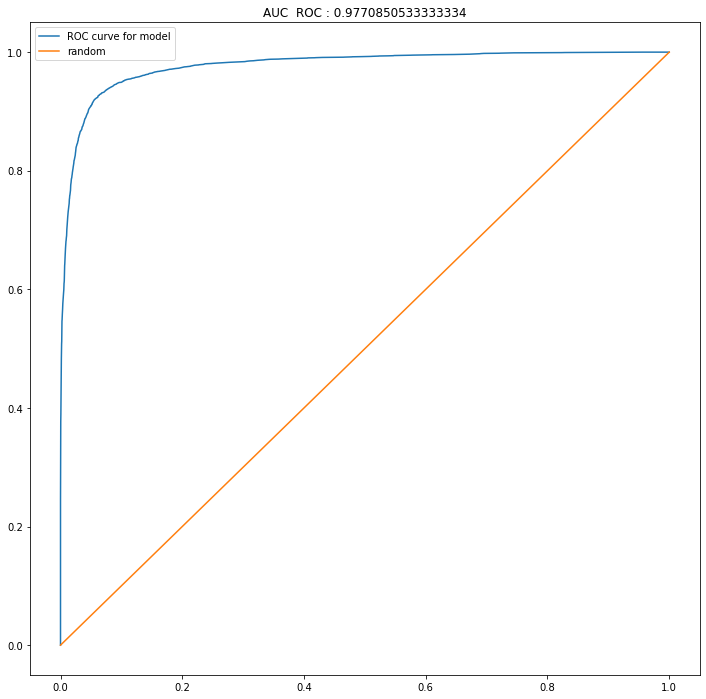

In [16]:
plot_ROC_curve_for_models(resnet18_experiment_results["best_model"])

# Larger Resnet (Resnet34)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

loss = 0.9816471848436581, accuracy : 0.5280914306640625, AUC ROC 0.7256295447622426: 100%|██████████| 469/469 [01:52<00:00,  4.16it/s]


TRAINING ; Loss: 0.9808 Acc: 0.5293 AUC ROC : 0.7266 Time taken : 112.77


100%|██████████| 118/118 [00:10<00:00, 10.89it/s]


VALIDATION : Loss: 2.4772 Acc: 0.5117 AUC ROC : 0.7749 Time taken : 10.85
New best, saving !
Epoch 1/19
----------


loss = 0.7737665544274033, accuracy : 0.7712701559066772, AUC ROC 0.9026485067704518: 100%|██████████| 469/469 [01:52<00:00,  4.18it/s]


TRAINING ; Loss: 0.7728 Acc: 0.7723 AUC ROC : 0.9033 Time taken : 112.37


100%|██████████| 118/118 [00:10<00:00, 10.88it/s]


VALIDATION : Loss: 0.7114 Acc: 0.8425 AUC ROC : 0.9532 Time taken : 10.86
New best, saving !
Epoch 2/19
----------


loss = 0.7242482405836864, accuracy : 0.8223790526390076, AUC ROC 0.9343836835909705: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]


TRAINING ; Loss: 0.7248 Acc: 0.8218 AUC ROC : 0.9341 Time taken : 112.53


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


VALIDATION : Loss: 1.2817 Acc: 0.7909 AUC ROC : 0.9277 Time taken : 10.91
Epoch 3/19
----------


loss = 0.7016803562000233, accuracy : 0.8458333611488342, AUC ROC 0.9481619101436894: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]


TRAINING ; Loss: 0.7014 Acc: 0.8460 AUC ROC : 0.9483 Time taken : 112.66


100%|██████████| 118/118 [00:10<00:00, 10.80it/s]


VALIDATION : Loss: 0.6800 Acc: 0.8816 AUC ROC : 0.9662 Time taken : 10.94
New best, saving !
Epoch 4/19
----------


loss = 0.67870466837319, accuracy : 0.868582010269165, AUC ROC 0.9592720221693346: 100%|██████████| 469/469 [01:52<00:00,  4.16it/s]


TRAINING ; Loss: 0.6789 Acc: 0.8685 AUC ROC : 0.9590 Time taken : 112.75


100%|██████████| 118/118 [00:10<00:00, 10.84it/s]


VALIDATION : Loss: 1.5169 Acc: 0.6852 AUC ROC : 0.9102 Time taken : 10.9
Epoch 5/19
----------


loss = 0.6753525216092345, accuracy : 0.8732863068580627, AUC ROC 0.9619107910124306: 100%|██████████| 469/469 [01:52<00:00,  4.16it/s]


TRAINING ; Loss: 0.6752 Acc: 0.8735 AUC ROC : 0.9620 Time taken : 112.71


100%|██████████| 118/118 [00:10<00:00, 10.86it/s]


VALIDATION : Loss: 0.5712 Acc: 0.8976 AUC ROC : 0.9743 Time taken : 10.88
New best, saving !
Epoch 6/19
----------


loss = 0.6616060290285336, accuracy : 0.8868615627288818, AUC ROC 0.9669527023560697: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]


TRAINING ; Loss: 0.6617 Acc: 0.8868 AUC ROC : 0.9669 Time taken : 112.6


100%|██████████| 118/118 [00:10<00:00, 10.90it/s]


VALIDATION : Loss: 0.8813 Acc: 0.8381 AUC ROC : 0.9473 Time taken : 10.84
Epoch 7/19
----------


loss = 0.6628680671415021, accuracy : 0.886155903339386, AUC ROC 0.9668121707016608: 100%|██████████| 469/469 [01:52<00:00,  4.18it/s]


TRAINING ; Loss: 0.6629 Acc: 0.8861 AUC ROC : 0.9668 Time taken : 112.32


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


VALIDATION : Loss: 0.5751 Acc: 0.9051 AUC ROC : 0.9755 Time taken : 10.91
New best, saving !
Epoch 8/19
----------


loss = 0.6515176015515481, accuracy : 0.897681474685669, AUC ROC 0.9710940006335192: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]


TRAINING ; Loss: 0.6515 Acc: 0.8977 AUC ROC : 0.9711 Time taken : 112.41


100%|██████████| 118/118 [00:10<00:00, 10.87it/s]


VALIDATION : Loss: 0.7034 Acc: 0.8789 AUC ROC : 0.9633 Time taken : 10.87
Epoch 9/19
----------


loss = 0.6542283106875676, accuracy : 0.8946236968040466, AUC ROC 0.970912812105659: 100%|██████████| 469/469 [01:53<00:00,  4.12it/s]


TRAINING ; Loss: 0.6540 Acc: 0.8948 AUC ROC : 0.9710 Time taken : 113.82


100%|██████████| 118/118 [00:11<00:00, 10.09it/s]


VALIDATION : Loss: 0.4939 Acc: 0.9113 AUC ROC : 0.9788 Time taken : 11.7
New best, saving !
Epoch 10/19
----------


loss = 0.6409509329385655, accuracy : 0.9088037610054016, AUC ROC 0.9760718800621259: 100%|██████████| 469/469 [01:52<00:00,  4.18it/s]


TRAINING ; Loss: 0.6412 Acc: 0.9086 AUC ROC : 0.9760 Time taken : 112.37


100%|██████████| 118/118 [00:10<00:00, 10.84it/s]


VALIDATION : Loss: 0.6015 Acc: 0.8887 AUC ROC : 0.9689 Time taken : 10.9
Epoch 11/19
----------


loss = 0.6434014390873652, accuracy : 0.90635085105896, AUC ROC 0.9751909257786724: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]


TRAINING ; Loss: 0.6434 Acc: 0.9064 AUC ROC : 0.9752 Time taken : 112.57


100%|██████████| 118/118 [00:10<00:00, 10.79it/s]


VALIDATION : Loss: 0.5056 Acc: 0.9155 AUC ROC : 0.9806 Time taken : 10.95
New best, saving !
Epoch 12/19
----------


loss = 0.6352858552368739, accuracy : 0.9150537848472595, AUC ROC 0.9781471499698556: 100%|██████████| 469/469 [01:54<00:00,  4.11it/s]


TRAINING ; Loss: 0.6356 Acc: 0.9147 AUC ROC : 0.9781 Time taken : 114.12


100%|██████████| 118/118 [00:11<00:00,  9.96it/s]


VALIDATION : Loss: 1.6801 Acc: 0.7607 AUC ROC : 0.9278 Time taken : 11.86
Epoch 13/19
----------


loss = 0.6483146479052883, accuracy : 0.9006720781326294, AUC ROC 0.9727267195336123: 100%|██████████| 469/469 [01:52<00:00,  4.16it/s]


TRAINING ; Loss: 0.6481 Acc: 0.9009 AUC ROC : 0.9727 Time taken : 112.76


100%|██████████| 118/118 [00:12<00:00,  9.80it/s]


VALIDATION : Loss: 0.4988 Acc: 0.9181 AUC ROC : 0.9820 Time taken : 12.05
New best, saving !
Epoch 14/19
----------


loss = 0.6300855087977584, accuracy : 0.9198924899101257, AUC ROC 0.9800005486842549: 100%|██████████| 469/469 [01:52<00:00,  4.18it/s]


TRAINING ; Loss: 0.6303 Acc: 0.9197 AUC ROC : 0.9800 Time taken : 112.32


100%|██████████| 118/118 [00:10<00:00, 10.75it/s]


VALIDATION : Loss: 0.5519 Acc: 0.8767 AUC ROC : 0.9683 Time taken : 10.99
Epoch 15/19
----------


loss = 0.6315301859250633, accuracy : 0.9183803796768188, AUC ROC 0.9801182739836339: 100%|██████████| 469/469 [01:52<00:00,  4.18it/s]


TRAINING ; Loss: 0.6313 Acc: 0.9186 AUC ROC : 0.9802 Time taken : 112.14


100%|██████████| 118/118 [00:10<00:00, 10.77it/s]


VALIDATION : Loss: 0.4395 Acc: 0.9257 AUC ROC : 0.9850 Time taken : 10.97
New best, saving !
Epoch 16/19
----------


loss = 0.6193331308262322, accuracy : 0.9311828017234802, AUC ROC 0.9837395575760991: 100%|██████████| 469/469 [01:52<00:00,  4.16it/s]


TRAINING ; Loss: 0.6195 Acc: 0.9310 AUC ROC : 0.9837 Time taken : 112.79


100%|██████████| 118/118 [00:11<00:00, 10.02it/s]


VALIDATION : Loss: 0.7798 Acc: 0.8881 AUC ROC : 0.9709 Time taken : 11.79
Epoch 17/19
----------


loss = 0.6290506451360641, accuracy : 0.921337366104126, AUC ROC 0.9806777756033913: 100%|██████████| 469/469 [01:51<00:00,  4.19it/s]


TRAINING ; Loss: 0.6290 Acc: 0.9214 AUC ROC : 0.9807 Time taken : 111.89


100%|██████████| 118/118 [00:10<00:00, 10.84it/s]


VALIDATION : Loss: 0.4488 Acc: 0.9255 AUC ROC : 0.9834 Time taken : 10.9
Epoch 18/19
----------


loss = 0.6172972611201707, accuracy : 0.9328293204307556, AUC ROC 0.9845230670892445: 100%|██████████| 469/469 [01:52<00:00,  4.19it/s]


TRAINING ; Loss: 0.6172 Acc: 0.9329 AUC ROC : 0.9845 Time taken : 112.1


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


VALIDATION : Loss: 0.5471 Acc: 0.8945 AUC ROC : 0.9742 Time taken : 10.91
Epoch 19/19
----------


loss = 0.6180609291599642, accuracy : 0.9317540526390076, AUC ROC 0.9845714935087391: 100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


TRAINING ; Loss: 0.6178 Acc: 0.9320 AUC ROC : 0.9847 Time taken : 111.73


100%|██████████| 118/118 [00:10<00:00, 10.83it/s]


VALIDATION : Loss: 0.4388 Acc: 0.9276 AUC ROC : 0.9853 Time taken : 10.91
New best, saving !
Training complete in 41m 16s


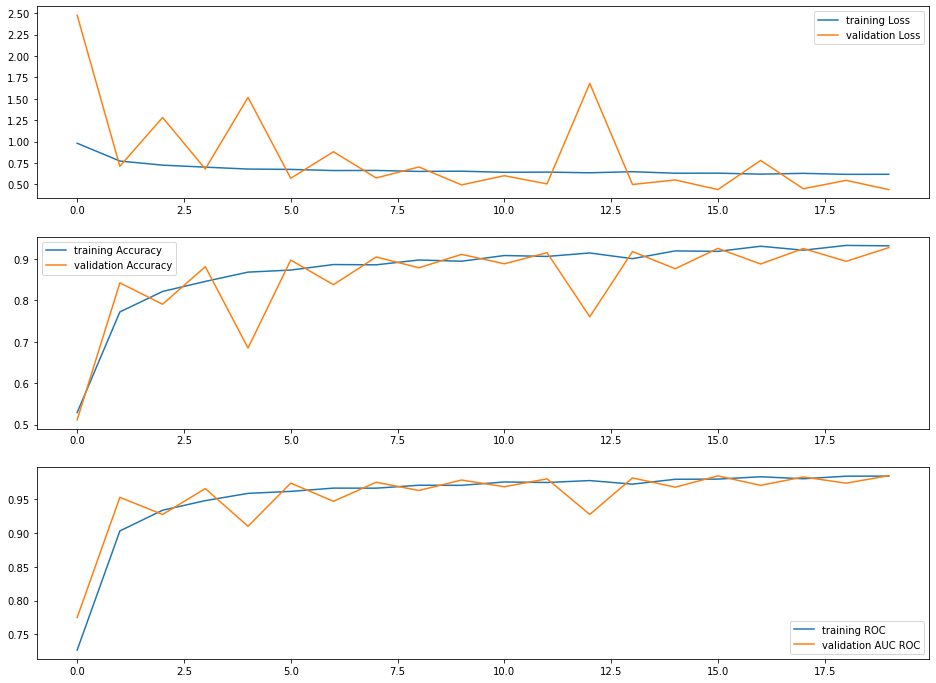

In [17]:
model = models.resnet34(True)
model.fc = nn.Linear(512, 3, bias=True)
resnet34_experiment_results = doExperiment(model, epochs=20, learning_rate=1e-4, input_size=(3, 125, 125),
                                           model_name="resnet34_pretrained_AUC={}.pth")

## AUC ROC curve

100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


epoch loss : 0.4933497447356582 , acc : 0.9258666666666667, AUC : 0.9847074666666668


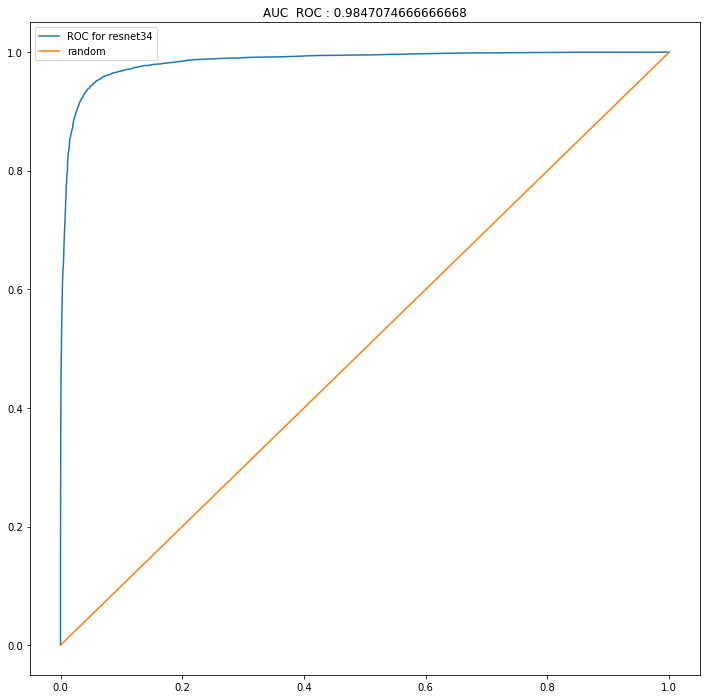

In [63]:
plot_ROC_curve_for_models(resnet34_experiment_results["best_model"], label="ROC for resnet34")

# Resnet 50

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

loss = 0.9452373470029524, accuracy : 0.5758400559425354, AUC ROC 0.765108021307864: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


TRAINING ; Loss: 0.9441 Acc: 0.5772 AUC ROC : 0.7663 Time taken : 182.29


100%|██████████| 118/118 [00:15<00:00,  7.43it/s]


VALIDATION : Loss: 1.4010 Acc: 0.6739 AUC ROC : 0.8385 Time taken : 15.9
New best, saving !
Epoch 1/19
----------


loss = 0.749883476508561, accuracy : 0.7945564389228821, AUC ROC 0.9220436061603768: 100%|██████████| 469/469 [03:02<00:00,  2.58it/s]


TRAINING ; Loss: 0.7491 Acc: 0.7956 AUC ROC : 0.9225 Time taken : 182.21


100%|██████████| 118/118 [00:15<00:00,  7.44it/s]


VALIDATION : Loss: 0.6373 Acc: 0.8637 AUC ROC : 0.9619 Time taken : 15.87
New best, saving !
Epoch 2/19
----------


loss = 0.7161357464328889, accuracy : 0.8310148119926453, AUC ROC 0.9405824860057224: 100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


TRAINING ; Loss: 0.7170 Acc: 0.8301 AUC ROC : 0.9401 Time taken : 181.7


100%|██████████| 118/118 [00:15<00:00,  7.47it/s]


VALIDATION : Loss: 2.0645 Acc: 0.7315 AUC ROC : 0.8906 Time taken : 15.82
Epoch 3/19
----------


loss = 0.7052548308526316, accuracy : 0.8427419662475586, AUC ROC 0.9461851415401615: 100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


TRAINING ; Loss: 0.7052 Acc: 0.8428 AUC ROC : 0.9463 Time taken : 181.57


100%|██████████| 118/118 [00:15<00:00,  7.46it/s]


VALIDATION : Loss: 0.6226 Acc: 0.8873 AUC ROC : 0.9711 Time taken : 15.83
New best, saving !
Epoch 4/19
----------


loss = 0.6881734630113007, accuracy : 0.8590390086174011, AUC ROC 0.9552105996065556: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


TRAINING ; Loss: 0.6884 Acc: 0.8589 AUC ROC : 0.9551 Time taken : 182.85


100%|██████████| 118/118 [00:16<00:00,  7.27it/s]


VALIDATION : Loss: 1.2071 Acc: 0.7061 AUC ROC : 0.8907 Time taken : 16.24
Epoch 5/19
----------


loss = 0.6844478567441304, accuracy : 0.8633736968040466, AUC ROC 0.957902935004118: 100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


TRAINING ; Loss: 0.6841 Acc: 0.8637 AUC ROC : 0.9581 Time taken : 181.47


100%|██████████| 118/118 [00:15<00:00,  7.47it/s]


VALIDATION : Loss: 0.5562 Acc: 0.8999 AUC ROC : 0.9758 Time taken : 15.82
New best, saving !
Epoch 6/19
----------


loss = 0.6677429103082226, accuracy : 0.8804771900177002, AUC ROC 0.9649191962219118: 100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


TRAINING ; Loss: 0.6682 Acc: 0.8800 AUC ROC : 0.9647 Time taken : 181.42


100%|██████████| 118/118 [00:15<00:00,  7.51it/s]


VALIDATION : Loss: 0.8149 Acc: 0.7436 AUC ROC : 0.9391 Time taken : 15.72
Epoch 7/19
----------


loss = 0.6736840110953136, accuracy : 0.8747648000717163, AUC ROC 0.9634438753913571: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


TRAINING ; Loss: 0.6734 Acc: 0.8750 AUC ROC : 0.9636 Time taken : 182.59


100%|██████████| 118/118 [00:16<00:00,  7.22it/s]


VALIDATION : Loss: 0.4712 Acc: 0.9101 AUC ROC : 0.9790 Time taken : 16.36
New best, saving !
Epoch 8/19
----------


loss = 0.655632411408168, accuracy : 0.8943212628364563, AUC ROC 0.9721502046153269: 100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


TRAINING ; Loss: 0.6562 Acc: 0.8937 AUC ROC : 0.9719 Time taken : 181.28


100%|██████████| 118/118 [00:15<00:00,  7.47it/s]


VALIDATION : Loss: 0.8078 Acc: 0.8660 AUC ROC : 0.9613 Time taken : 15.82
Epoch 9/19
----------


loss = 0.6609633282948566, accuracy : 0.8877688646316528, AUC ROC 0.9696041549148088: 100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


TRAINING ; Loss: 0.6605 Acc: 0.8882 AUC ROC : 0.9698 Time taken : 181.02


100%|██████████| 118/118 [00:15<00:00,  7.48it/s]


VALIDATION : Loss: 0.5520 Acc: 0.9131 AUC ROC : 0.9808 Time taken : 15.79
New best, saving !
Epoch 10/19
----------


loss = 0.6491445226054038, accuracy : 0.9000672101974487, AUC ROC 0.9744480494836445: 100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


TRAINING ; Loss: 0.6493 Acc: 0.8999 AUC ROC : 0.9743 Time taken : 180.94


100%|██████████| 118/118 [00:15<00:00,  7.51it/s]


VALIDATION : Loss: 1.5166 Acc: 0.8388 AUC ROC : 0.9533 Time taken : 15.72
Epoch 11/19
----------


loss = 0.6528782036996656, accuracy : 0.8961021900177002, AUC ROC 0.9727752793530923: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


TRAINING ; Loss: 0.6527 Acc: 0.8963 AUC ROC : 0.9728 Time taken : 182.41


100%|██████████| 118/118 [00:16<00:00,  7.27it/s]


VALIDATION : Loss: 0.4039 Acc: 0.9157 AUC ROC : 0.9819 Time taken : 16.24
New best, saving !
Epoch 12/19
----------


loss = 0.6374301895018547, accuracy : 0.9120295643806458, AUC ROC 0.9778644533021311: 100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


TRAINING ; Loss: 0.6376 Acc: 0.9118 AUC ROC : 0.9778 Time taken : 180.92


100%|██████████| 118/118 [00:15<00:00,  7.44it/s]


VALIDATION : Loss: 0.8856 Acc: 0.8436 AUC ROC : 0.9629 Time taken : 15.86
Epoch 13/19
----------


loss = 0.6414851271977988, accuracy : 0.9075269103050232, AUC ROC 0.9770866246131554: 100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


TRAINING ; Loss: 0.6413 Acc: 0.9077 AUC ROC : 0.9772 Time taken : 181.33


100%|██████████| 118/118 [00:16<00:00,  7.31it/s]


VALIDATION : Loss: 0.4334 Acc: 0.9216 AUC ROC : 0.9835 Time taken : 16.16
New best, saving !
Epoch 14/19
----------


loss = 0.6332622998504228, accuracy : 0.9167338609695435, AUC ROC 0.9801522515630868: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


TRAINING ; Loss: 0.6335 Acc: 0.9165 AUC ROC : 0.9801 Time taken : 182.82


100%|██████████| 118/118 [00:16<00:00,  7.23it/s]


VALIDATION : Loss: 1.3509 Acc: 0.8324 AUC ROC : 0.9537 Time taken : 16.32
Epoch 15/19
----------


loss = 0.6499623466563481, accuracy : 0.8998656272888184, AUC ROC 0.9737608565082265: 100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


TRAINING ; Loss: 0.6497 Acc: 0.9001 AUC ROC : 0.9739 Time taken : 180.84


100%|██████████| 118/118 [00:15<00:00,  7.45it/s]


VALIDATION : Loss: 0.3786 Acc: 0.9233 AUC ROC : 0.9836 Time taken : 15.85
New best, saving !
Epoch 16/19
----------


loss = 0.6325285669296018, accuracy : 0.9171707034111023, AUC ROC 0.9802496782277587: 100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


TRAINING ; Loss: 0.6326 Acc: 0.9171 AUC ROC : 0.9803 Time taken : 182.08


100%|██████████| 118/118 [00:16<00:00,  7.24it/s]


VALIDATION : Loss: 1.1464 Acc: 0.8023 AUC ROC : 0.9382 Time taken : 16.31
Epoch 17/19
----------


loss = 0.6342764550639737, accuracy : 0.9154906272888184, AUC ROC 0.9800167024303352: 100%|██████████| 469/469 [03:00<00:00,  2.60it/s]


TRAINING ; Loss: 0.6341 Acc: 0.9156 AUC ROC : 0.9801 Time taken : 180.47


100%|██████████| 118/118 [00:15<00:00,  7.44it/s]


VALIDATION : Loss: 0.4109 Acc: 0.9160 AUC ROC : 0.9832 Time taken : 15.86
Epoch 18/19
----------


loss = 0.6263186045872268, accuracy : 0.9238911271095276, AUC ROC 0.9831098230811367: 100%|██████████| 469/469 [03:00<00:00,  2.60it/s]


TRAINING ; Loss: 0.6264 Acc: 0.9239 AUC ROC : 0.9831 Time taken : 180.51


100%|██████████| 118/118 [00:15<00:00,  7.47it/s]


VALIDATION : Loss: 0.8826 Acc: 0.8744 AUC ROC : 0.9731 Time taken : 15.81
Epoch 19/19
----------


loss = 0.6281805547334814, accuracy : 0.9213709831237793, AUC ROC 0.9816548048164764: 100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


TRAINING ; Loss: 0.6283 Acc: 0.9213 AUC ROC : 0.9816 Time taken : 181.7


100%|██████████| 118/118 [00:16<00:00,  7.23it/s]


VALIDATION : Loss: 0.4597 Acc: 0.9244 AUC ROC : 0.9840 Time taken : 16.33
New best, saving !
Training complete in 65m 55s


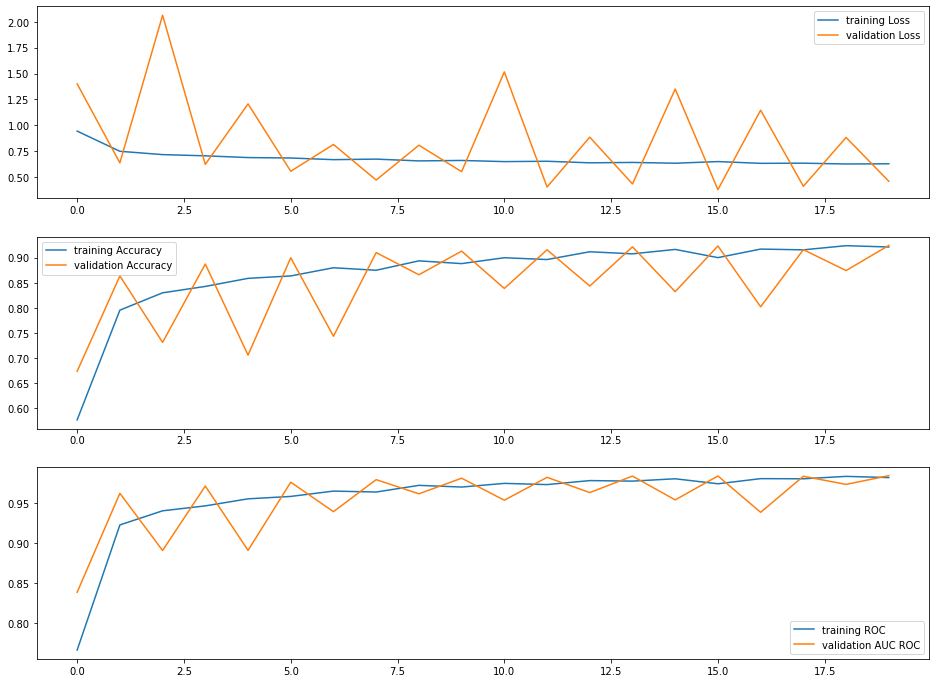

In [18]:
model = models.resnet50(True)
model.fc = nn.Linear(2048, 3, bias=True)
resnet50_experiment_results = doExperiment(model, epochs=20, learning_rate=1e-4, input_size=(3, 125, 125),
                                           model_name="resnet34_pretrained_AUC={}.pth")

## Plot ROC

100%|██████████| 118/118 [00:16<00:00,  7.35it/s]


epoch loss : 0.4597132459640503 , acc : 0.9244, AUC : 0.9839815333333334


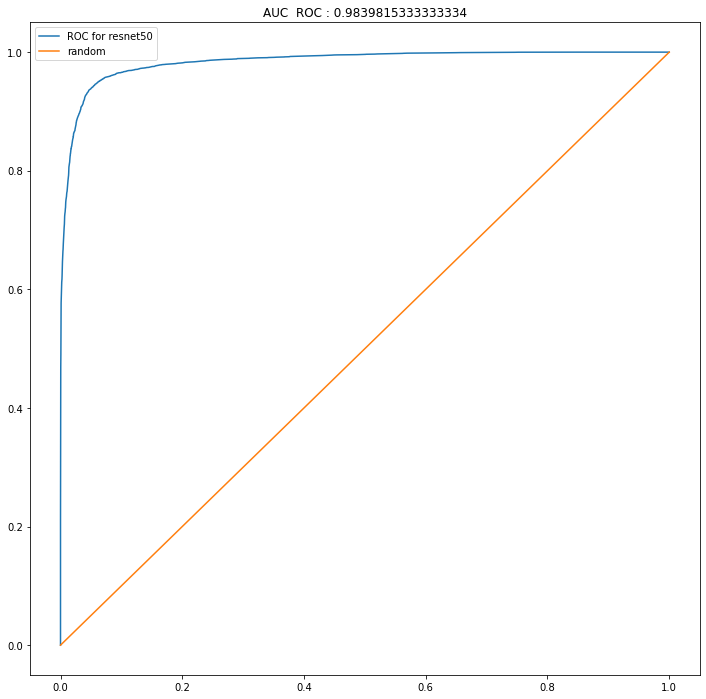

In [19]:
plot_ROC_curve_for_models(resnet50_experiment_results["best_model"], label="ROC for resnet50")

# Resnet118

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

loss = 0.9894993934580075, accuracy : 0.5149865746498108, AUC ROC 0.7138973864079299: 100%|██████████| 469/469 [04:53<00:00,  1.60it/s]


TRAINING ; Loss: 0.9883 Acc: 0.5164 AUC ROC : 0.7153 Time taken : 293.69


100%|██████████| 118/118 [00:24<00:00,  4.75it/s]


VALIDATION : Loss: 2.6910 Acc: 0.5911 AUC ROC : 0.8046 Time taken : 24.84
New best, saving !
Epoch 1/19
----------


loss = 0.7793164828772186, accuracy : 0.764549732208252, AUC ROC 0.9025284161195203: 100%|██████████| 469/469 [04:49<00:00,  1.62it/s]


TRAINING ; Loss: 0.7785 Acc: 0.7654 AUC ROC : 0.9031 Time taken : 289.31


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


VALIDATION : Loss: 0.7131 Acc: 0.8219 AUC ROC : 0.9481 Time taken : 23.88
New best, saving !
Epoch 2/19
----------


loss = 0.7251083318905164, accuracy : 0.8209677338600159, AUC ROC 0.9364050878809632: 100%|██████████| 469/469 [04:48<00:00,  1.62it/s]


TRAINING ; Loss: 0.7252 Acc: 0.8209 AUC ROC : 0.9364 Time taken : 288.85


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


VALIDATION : Loss: 2.7924 Acc: 0.6940 AUC ROC : 0.8859 Time taken : 23.84
Epoch 3/19
----------


loss = 0.7023847772229103, accuracy : 0.844287633895874, AUC ROC 0.9491535349534962: 100%|██████████| 469/469 [04:48<00:00,  1.63it/s]


TRAINING ; Loss: 0.7019 Acc: 0.8448 AUC ROC : 0.9494 Time taken : 288.57


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


VALIDATION : Loss: 0.5354 Acc: 0.8904 AUC ROC : 0.9721 Time taken : 23.86
New best, saving !
Epoch 4/19
----------


loss = 0.6812860510682547, accuracy : 0.8669354915618896, AUC ROC 0.9587562525821886: 100%|██████████| 469/469 [04:48<00:00,  1.63it/s]


TRAINING ; Loss: 0.6817 Acc: 0.8666 AUC ROC : 0.9585 Time taken : 288.57


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


VALIDATION : Loss: 1.1396 Acc: 0.7868 AUC ROC : 0.9202 Time taken : 23.85
Epoch 5/19
----------


loss = 0.6782041625310016, accuracy : 0.8709341287612915, AUC ROC 0.9613563620193339: 100%|██████████| 469/469 [04:47<00:00,  1.63it/s]


TRAINING ; Loss: 0.6779 Acc: 0.8712 AUC ROC : 0.9615 Time taken : 288.04


100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


VALIDATION : Loss: 0.5207 Acc: 0.8939 AUC ROC : 0.9750 Time taken : 23.79
New best, saving !
Epoch 6/19
----------


loss = 0.6655751202696113, accuracy : 0.8835013508796692, AUC ROC 0.9664928146460503: 100%|██████████| 469/469 [04:48<00:00,  1.63it/s]


TRAINING ; Loss: 0.6661 Acc: 0.8829 AUC ROC : 0.9662 Time taken : 288.2


100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


VALIDATION : Loss: 1.6169 Acc: 0.8160 AUC ROC : 0.9403 Time taken : 23.77
Epoch 7/19
----------


loss = 0.6692302191129295, accuracy : 0.8798723220825195, AUC ROC 0.9654800586342462: 100%|██████████| 469/469 [04:46<00:00,  1.64it/s]


TRAINING ; Loss: 0.6692 Acc: 0.8800 AUC ROC : 0.9655 Time taken : 286.97


100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


VALIDATION : Loss: 0.5349 Acc: 0.9011 AUC ROC : 0.9765 Time taken : 23.65
New best, saving !
Epoch 8/19
----------


loss = 0.653399533097462, accuracy : 0.8955981135368347, AUC ROC 0.9714763012540247: 100%|██████████| 469/469 [04:46<00:00,  1.63it/s]


TRAINING ; Loss: 0.6537 Acc: 0.8953 AUC ROC : 0.9713 Time taken : 287.09


100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


VALIDATION : Loss: 1.4334 Acc: 0.7827 AUC ROC : 0.9350 Time taken : 23.74
Epoch 9/19
----------


loss = 0.6630662505344678, accuracy : 0.885349452495575, AUC ROC 0.9679835245909149: 100%|██████████| 469/469 [04:46<00:00,  1.64it/s]


TRAINING ; Loss: 0.6631 Acc: 0.8854 AUC ROC : 0.9680 Time taken : 286.71


100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


VALIDATION : Loss: 0.5629 Acc: 0.8995 AUC ROC : 0.9760 Time taken : 23.71
Epoch 10/19
----------


loss = 0.6513431419608413, accuracy : 0.8983871340751648, AUC ROC 0.9720287752541649: 100%|██████████| 469/469 [04:46<00:00,  1.64it/s]


TRAINING ; Loss: 0.6518 Acc: 0.8979 AUC ROC : 0.9719 Time taken : 286.32


100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


VALIDATION : Loss: 2.0223 Acc: 0.8109 AUC ROC : 0.9388 Time taken : 23.57
Epoch 11/19
----------


loss = 0.6489435381786798, accuracy : 0.9006384611129761, AUC ROC 0.9737138789879077: 100%|██████████| 469/469 [04:44<00:00,  1.65it/s]


TRAINING ; Loss: 0.6486 Acc: 0.9010 AUC ROC : 0.9738 Time taken : 284.83


100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


VALIDATION : Loss: 0.4385 Acc: 0.9161 AUC ROC : 0.9810 Time taken : 23.46
New best, saving !
Epoch 12/19
----------


loss = 0.637364613112583, accuracy : 0.9125000238418579, AUC ROC 0.9781497880776833: 100%|██████████| 469/469 [04:44<00:00,  1.65it/s]


TRAINING ; Loss: 0.6372 Acc: 0.9127 AUC ROC : 0.9781 Time taken : 284.92


100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


VALIDATION : Loss: 0.7034 Acc: 0.8673 AUC ROC : 0.9629 Time taken : 23.44
Epoch 13/19
----------


loss = 0.6438072923691042, accuracy : 0.9063172340393066, AUC ROC 0.9761376305157894: 100%|██████████| 469/469 [04:43<00:00,  1.65it/s]


TRAINING ; Loss: 0.6438 Acc: 0.9063 AUC ROC : 0.9761 Time taken : 283.69


100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


VALIDATION : Loss: 0.4331 Acc: 0.9167 AUC ROC : 0.9806 Time taken : 23.4
Epoch 14/19
----------


loss = 0.63121116827893, accuracy : 0.9186491966247559, AUC ROC 0.9807372116541536: 100%|██████████| 469/469 [04:43<00:00,  1.65it/s]


TRAINING ; Loss: 0.6314 Acc: 0.9184 AUC ROC : 0.9807 Time taken : 283.73


100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


VALIDATION : Loss: 0.7615 Acc: 0.8683 AUC ROC : 0.9660 Time taken : 23.38
Epoch 15/19
----------


loss = 0.6420082264049078, accuracy : 0.9072244763374329, AUC ROC 0.9770471210158976: 100%|██████████| 469/469 [04:42<00:00,  1.66it/s]


TRAINING ; Loss: 0.6418 Acc: 0.9075 AUC ROC : 0.9771 Time taken : 282.38


100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


VALIDATION : Loss: 0.4819 Acc: 0.9175 AUC ROC : 0.9817 Time taken : 23.34
New best, saving !
Epoch 16/19
----------


loss = 0.628361794769123, accuracy : 0.9220430254936218, AUC ROC 0.9807683381577798: 100%|██████████| 469/469 [04:42<00:00,  1.66it/s]


TRAINING ; Loss: 0.6286 Acc: 0.9218 AUC ROC : 0.9807 Time taken : 282.35


100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


VALIDATION : Loss: 0.7480 Acc: 0.8821 AUC ROC : 0.9684 Time taken : 23.32
Epoch 17/19
----------


loss = 0.6324773533369905, accuracy : 0.9174731373786926, AUC ROC 0.9806082259927272: 100%|██████████| 469/469 [04:40<00:00,  1.67it/s]


TRAINING ; Loss: 0.6323 Acc: 0.9176 AUC ROC : 0.9807 Time taken : 281.11


100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


VALIDATION : Loss: 0.4946 Acc: 0.9205 AUC ROC : 0.9832 Time taken : 23.28
New best, saving !
Epoch 18/19
----------


loss = 0.6205293541313499, accuracy : 0.9297043085098267, AUC ROC 0.9840397051866443: 100%|██████████| 469/469 [04:40<00:00,  1.67it/s]


TRAINING ; Loss: 0.6210 Acc: 0.9292 AUC ROC : 0.9839 Time taken : 280.65


100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


VALIDATION : Loss: 1.0979 Acc: 0.8584 AUC ROC : 0.9563 Time taken : 23.17
Epoch 19/19
----------


loss = 0.6311983355911829, accuracy : 0.9192876815795898, AUC ROC 0.9803428901971194: 100%|██████████| 469/469 [04:39<00:00,  1.68it/s]


TRAINING ; Loss: 0.6311 Acc: 0.9194 AUC ROC : 0.9804 Time taken : 279.38


100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


VALIDATION : Loss: 0.4378 Acc: 0.9183 AUC ROC : 0.9823 Time taken : 23.22
Training complete in 103m 12s


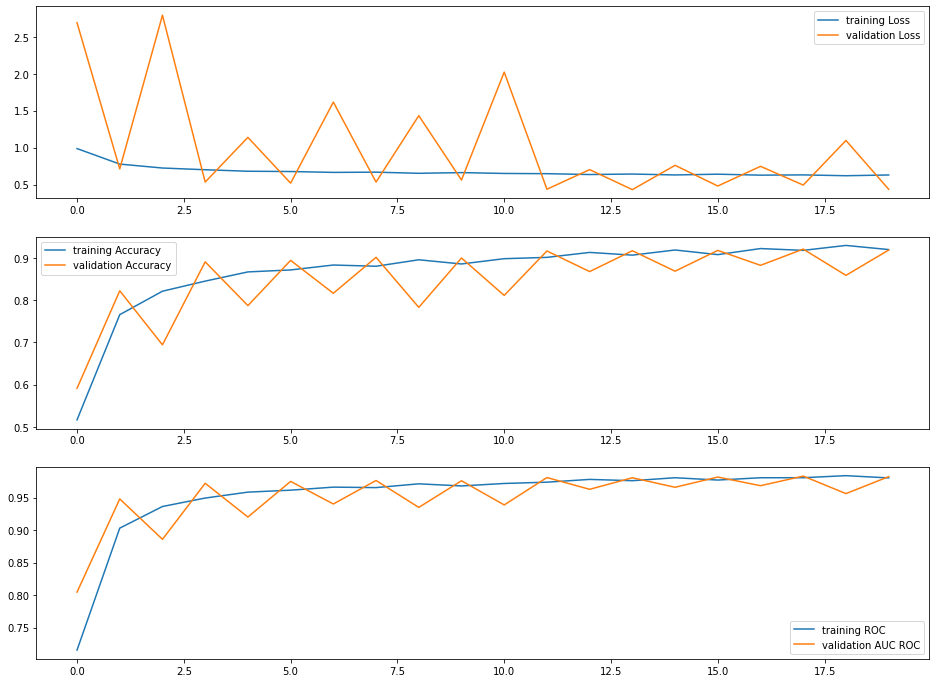

In [23]:
model = models.resnet101(True)
model.fc = nn.Linear(2048, 3, bias=True)
resnet118_experiment_results = doExperiment(model, epochs=20, learning_rate=1e-4, input_size=(3, 125, 125),
                                           model_name="resnet118_pretrained_AUC={}.pth")

## Plot AUC

100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


epoch loss : 0.4946114038277728 , acc : 0.9205333333333334, AUC : 0.9832258133333333


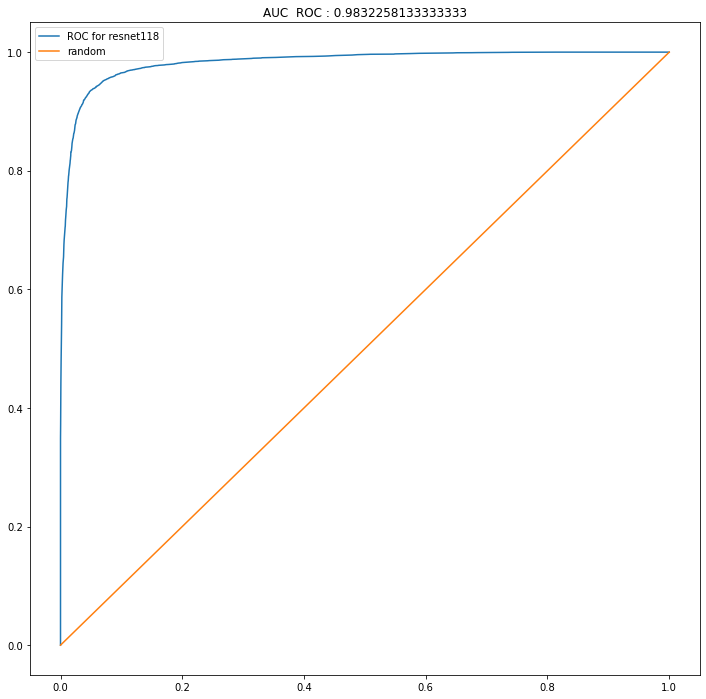

In [24]:
plot_ROC_curve_for_models(resnet118_experiment_results["best_model"], label="ROC for resnet118")

# Efficient Net b2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]             864
       BatchNorm2d-2           [-1, 32, 63, 63]              64
              SiLU-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 32, 63, 63]             288
       BatchNorm2d-5           [-1, 32, 63, 63]              64
              SiLU-6           [-1, 32, 63, 63]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 63, 63]               0
           Conv2d-13           [-1, 16, 63, 63]             512
      BatchNorm2d-14           [-1, 16,

loss = 0.9998508803306088, accuracy : 0.5073589086532593, AUC ROC 0.6996916294172495: 100%|██████████| 469/469 [02:32<00:00,  3.07it/s]


TRAINING ; Loss: 0.9989 Acc: 0.5086 AUC ROC : 0.7009 Time taken : 152.76


100%|██████████| 118/118 [00:11<00:00,  9.86it/s]


VALIDATION : Loss: 1.9410 Acc: 0.6407 AUC ROC : 0.8158 Time taken : 11.98
New best, saving !
Epoch 1/19
----------


loss = 0.8111781524073693, accuracy : 0.7290322780609131, AUC ROC 0.8756858073771895: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.8107 Acc: 0.7295 AUC ROC : 0.8760 Time taken : 151.56


100%|██████████| 118/118 [00:11<00:00, 10.06it/s]


VALIDATION : Loss: 1.2875 Acc: 0.7775 AUC ROC : 0.9137 Time taken : 11.74
New best, saving !
Epoch 2/19
----------


loss = 0.7577617429917859, accuracy : 0.7870631814002991, AUC ROC 0.9098420238436639: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.7580 Acc: 0.7868 AUC ROC : 0.9096 Time taken : 151.67


100%|██████████| 118/118 [00:11<00:00, 10.08it/s]


VALIDATION : Loss: 1.2800 Acc: 0.7859 AUC ROC : 0.9145 Time taken : 11.72
New best, saving !
Epoch 3/19
----------


loss = 0.7249926692696028, accuracy : 0.8212701678276062, AUC ROC 0.9299321851630508: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.7248 Acc: 0.8214 AUC ROC : 0.9301 Time taken : 151.6


100%|██████████| 118/118 [00:11<00:00, 10.13it/s]


VALIDATION : Loss: 1.0039 Acc: 0.8464 AUC ROC : 0.9481 Time taken : 11.67
New best, saving !
Epoch 4/19
----------


loss = 0.7000645610593981, accuracy : 0.8470430374145508, AUC ROC 0.9443376444548429: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.7003 Acc: 0.8468 AUC ROC : 0.9442 Time taken : 151.6


100%|██████████| 118/118 [00:11<00:00, 10.02it/s]


VALIDATION : Loss: 1.4640 Acc: 0.8083 AUC ROC : 0.9262 Time taken : 11.8
Epoch 5/19
----------


loss = 0.6893796901549062, accuracy : 0.8578629493713379, AUC ROC 0.9494113306652864: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6895 Acc: 0.8578 AUC ROC : 0.9493 Time taken : 151.32


100%|██████████| 118/118 [00:11<00:00, 10.13it/s]


VALIDATION : Loss: 0.9176 Acc: 0.8693 AUC ROC : 0.9612 Time taken : 11.67
New best, saving !
Epoch 6/19
----------


loss = 0.6730149161431097, accuracy : 0.8753024339675903, AUC ROC 0.9577626188754271: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6732 Acc: 0.8751 AUC ROC : 0.9577 Time taken : 151.48


100%|██████████| 118/118 [00:11<00:00, 10.08it/s]


VALIDATION : Loss: 1.8841 Acc: 0.7887 AUC ROC : 0.9195 Time taken : 11.72
Epoch 7/19
----------


loss = 0.6727938226474228, accuracy : 0.875268816947937, AUC ROC 0.9583911717154906: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6727 Acc: 0.8754 AUC ROC : 0.9584 Time taken : 151.36


100%|██████████| 118/118 [00:11<00:00, 10.07it/s]


VALIDATION : Loss: 0.8550 Acc: 0.8847 AUC ROC : 0.9686 Time taken : 11.73
New best, saving !
Epoch 8/19
----------


loss = 0.6567788995722289, accuracy : 0.8930779695510864, AUC ROC 0.9653479027934756: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6572 Acc: 0.8926 AUC ROC : 0.9652 Time taken : 151.44


100%|██████████| 118/118 [00:11<00:00, 10.08it/s]


VALIDATION : Loss: 0.9779 Acc: 0.8592 AUC ROC : 0.9536 Time taken : 11.73
Epoch 9/19
----------


loss = 0.6611877454224453, accuracy : 0.8876344561576843, AUC ROC 0.9628559520838613: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6609 Acc: 0.8880 AUC ROC : 0.9630 Time taken : 151.24


100%|██████████| 118/118 [00:11<00:00, 10.01it/s]


VALIDATION : Loss: 0.7835 Acc: 0.8917 AUC ROC : 0.9731 Time taken : 11.81
New best, saving !
Epoch 10/19
----------


loss = 0.647350218988234, accuracy : 0.9022177457809448, AUC ROC 0.9696199359342268: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6475 Acc: 0.9020 AUC ROC : 0.9695 Time taken : 151.41


100%|██████████| 118/118 [00:11<00:00, 10.08it/s]


VALIDATION : Loss: 0.9965 Acc: 0.8671 AUC ROC : 0.9611 Time taken : 11.73
Epoch 11/19
----------


loss = 0.6471128076635381, accuracy : 0.901780903339386, AUC ROC 0.9711438138571613: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6469 Acc: 0.9021 AUC ROC : 0.9712 Time taken : 151.26


100%|██████████| 118/118 [00:11<00:00, 10.08it/s]


VALIDATION : Loss: 0.7107 Acc: 0.9020 AUC ROC : 0.9746 Time taken : 11.73
New best, saving !
Epoch 12/19
----------


loss = 0.6372221889034394, accuracy : 0.9126680493354797, AUC ROC 0.9745870472122284: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6376 Acc: 0.9124 AUC ROC : 0.9743 Time taken : 151.36


100%|██████████| 118/118 [00:11<00:00, 10.01it/s]


VALIDATION : Loss: 0.9501 Acc: 0.8884 AUC ROC : 0.9651 Time taken : 11.8
Epoch 13/19
----------


loss = 0.6406633916721549, accuracy : 0.9091398119926453, AUC ROC 0.9734505978202419: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6404 Acc: 0.9095 AUC ROC : 0.9736 Time taken : 151.23


100%|██████████| 118/118 [00:11<00:00, 10.03it/s]


VALIDATION : Loss: 0.7327 Acc: 0.9065 AUC ROC : 0.9771 Time taken : 11.77
New best, saving !
Epoch 14/19
----------


loss = 0.628805572114965, accuracy : 0.9209341406822205, AUC ROC 0.9781448868915041: 100%|██████████| 469/469 [02:31<00:00,  3.11it/s]


TRAINING ; Loss: 0.6289 Acc: 0.9209 AUC ROC : 0.9781 Time taken : 151.16


100%|██████████| 118/118 [00:11<00:00, 10.05it/s]


VALIDATION : Loss: 1.1572 Acc: 0.8635 AUC ROC : 0.9576 Time taken : 11.75
Epoch 15/19
----------


loss = 0.6341903098167911, accuracy : 0.9156585931777954, AUC ROC 0.9761902051478925: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6339 Acc: 0.9160 AUC ROC : 0.9764 Time taken : 151.35


100%|██████████| 118/118 [00:11<00:00, 10.10it/s]


VALIDATION : Loss: 0.7709 Acc: 0.9096 AUC ROC : 0.9771 Time taken : 11.71
New best, saving !
Epoch 16/19
----------


loss = 0.6235418964457768, accuracy : 0.9265121221542358, AUC ROC 0.9792046601686738: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6235 Acc: 0.9265 AUC ROC : 0.9792 Time taken : 151.34


100%|██████████| 118/118 [00:11<00:00, 10.05it/s]


VALIDATION : Loss: 0.8522 Acc: 0.8867 AUC ROC : 0.9724 Time taken : 11.76
Epoch 17/19
----------


loss = 0.624194121745325, accuracy : 0.9258736968040466, AUC ROC 0.980514944508425: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6243 Acc: 0.9258 AUC ROC : 0.9805 Time taken : 151.26


100%|██████████| 118/118 [00:11<00:00, 10.11it/s]


VALIDATION : Loss: 0.5980 Acc: 0.9184 AUC ROC : 0.9798 Time taken : 11.69
New best, saving !
Epoch 18/19
----------


loss = 0.6167820731798808, accuracy : 0.9337365627288818, AUC ROC 0.9818364764793879: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6170 Acc: 0.9335 AUC ROC : 0.9817 Time taken : 151.34


100%|██████████| 118/118 [00:11<00:00, 10.07it/s]


VALIDATION : Loss: 0.7631 Acc: 0.8936 AUC ROC : 0.9689 Time taken : 11.73
Epoch 19/19
----------


loss = 0.6196450418041598, accuracy : 0.9307795763015747, AUC ROC 0.9810676672515637: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


TRAINING ; Loss: 0.6195 Acc: 0.9309 AUC ROC : 0.9811 Time taken : 151.41


100%|██████████| 118/118 [00:11<00:00, 10.13it/s]


VALIDATION : Loss: 0.6442 Acc: 0.9201 AUC ROC : 0.9783 Time taken : 11.66
Training complete in 54m 26s


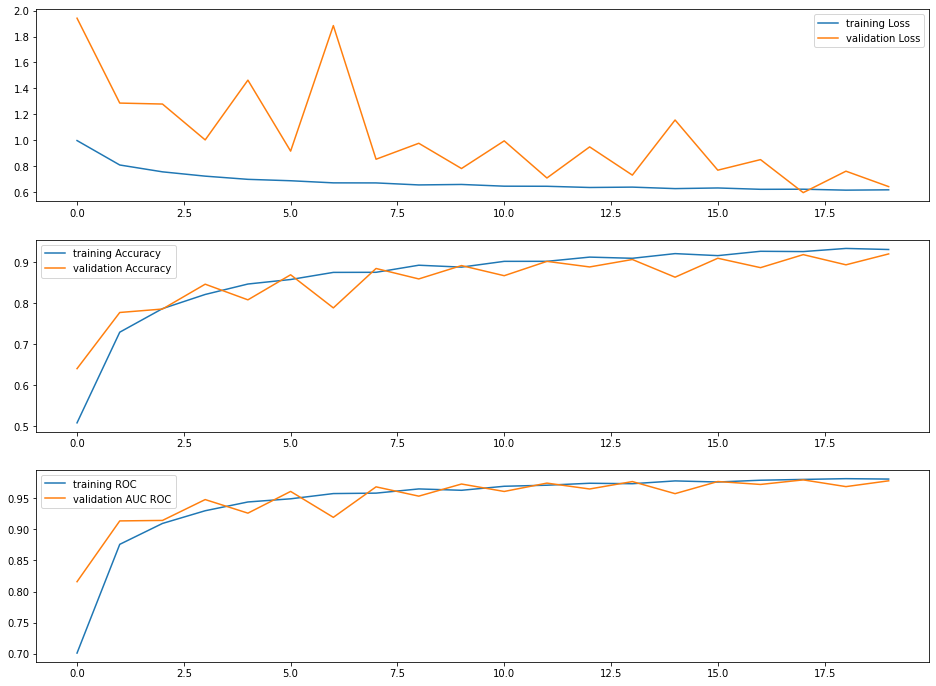

In [26]:
model = models.efficientnet_b2(True)
model.classifier = nn.Sequential(nn.Dropout(0.3),
                                 nn.Linear(in_features=1408, out_features=3, bias=True))
efficient_net_b2_results = doExperiment(model, epochs=20, learning_rate=1e-4, input_size=(3, 125, 125),
                                  model_name="efficientnet_b2_pretrained_AUC={}.pth")

## Plot ROC curve

100%|██████████| 118/118 [00:11<00:00, 10.01it/s]


epoch loss : 0.5980231865962347 , acc : 0.9184, AUC : 0.9797790666666667


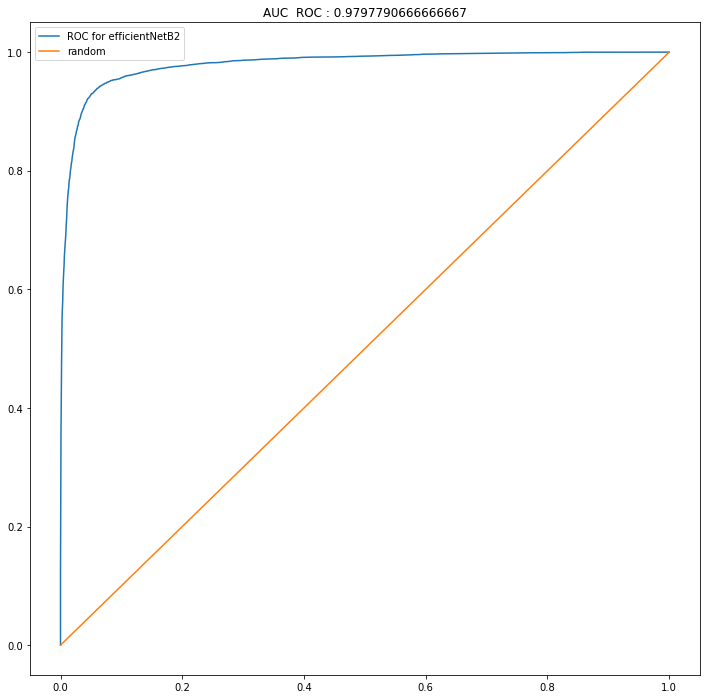

In [27]:
plot_ROC_curve_for_models(efficient_net_b2_results["best_model"], label="ROC for efficientNetB2")

# Efficient Net b3

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 63, 63]           1,080
       BatchNorm2d-2           [-1, 40, 63, 63]              80
              SiLU-3           [-1, 40, 63, 63]               0
            Conv2d-4           [-1, 40, 63, 63]             360
       BatchNorm2d-5           [-1, 40, 63, 63]              80
              SiLU-6           [-1, 40, 63, 63]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 63, 63]               0
           Conv2d-13           [-1, 24, 63, 63]             960
      BatchNorm2d-14           [-1, 24,

loss = 1.01588164670493, accuracy : 0.48457661271095276, AUC ROC 0.6793224216690157: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 1.0149 Acc: 0.4858 AUC ROC : 0.6806 Time taken : 192.12


100%|██████████| 118/118 [00:14<00:00,  8.34it/s]


VALIDATION : Loss: 1.3897 Acc: 0.6764 AUC ROC : 0.8358 Time taken : 14.17
New best, saving !
Epoch 1/19
----------


loss = 0.8077649439534833, accuracy : 0.7352150678634644, AUC ROC 0.8743884503181323: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.8072 Acc: 0.7358 AUC ROC : 0.8749 Time taken : 192.33


100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


VALIDATION : Loss: 1.0372 Acc: 0.7937 AUC ROC : 0.9183 Time taken : 14.25
New best, saving !
Epoch 2/19
----------


loss = 0.74350631929213, accuracy : 0.8010081052780151, AUC ROC 0.9195471175193838: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.7434 Acc: 0.8010 AUC ROC : 0.9198 Time taken : 192.32


100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


VALIDATION : Loss: 1.1391 Acc: 0.7925 AUC ROC : 0.9240 Time taken : 14.29
New best, saving !
Epoch 3/19
----------


loss = 0.716926376024882, accuracy : 0.829301118850708, AUC ROC 0.9341055880946728: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.7170 Acc: 0.8293 AUC ROC : 0.9341 Time taken : 192.18


100%|██████████| 118/118 [00:14<00:00,  8.32it/s]


VALIDATION : Loss: 1.0203 Acc: 0.8489 AUC ROC : 0.9477 Time taken : 14.21
New best, saving !
Epoch 4/19
----------


loss = 0.690885087238845, accuracy : 0.8572244644165039, AUC ROC 0.9465852976540653: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6913 Acc: 0.8568 AUC ROC : 0.9465 Time taken : 192.26


100%|██████████| 118/118 [00:14<00:00,  8.33it/s]


VALIDATION : Loss: 1.3363 Acc: 0.7991 AUC ROC : 0.9222 Time taken : 14.19
Epoch 5/19
----------


loss = 0.6855830903976194, accuracy : 0.8628360629081726, AUC ROC 0.9512541556735599: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6854 Acc: 0.8630 AUC ROC : 0.9514 Time taken : 192.33


100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


VALIDATION : Loss: 0.9246 Acc: 0.8779 AUC ROC : 0.9626 Time taken : 14.25
New best, saving !
Epoch 6/19
----------


loss = 0.6653547078050593, accuracy : 0.8837365508079529, AUC ROC 0.9619520360466159: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6652 Acc: 0.8838 AUC ROC : 0.9621 Time taken : 192.3


100%|██████████| 118/118 [00:14<00:00,  8.33it/s]


VALIDATION : Loss: 0.9887 Acc: 0.8604 AUC ROC : 0.9526 Time taken : 14.19
Epoch 7/19
----------


loss = 0.6623080608665303, accuracy : 0.8870295882225037, AUC ROC 0.96329000324176: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6620 Acc: 0.8873 AUC ROC : 0.9634 Time taken : 192.23


100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


VALIDATION : Loss: 0.8247 Acc: 0.8927 AUC ROC : 0.9672 Time taken : 14.26
New best, saving !
Epoch 8/19
----------


loss = 0.6472566313641046, accuracy : 0.9019153118133545, AUC ROC 0.9701768463690851: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6473 Acc: 0.9019 AUC ROC : 0.9702 Time taken : 192.21


100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


VALIDATION : Loss: 1.0957 Acc: 0.8548 AUC ROC : 0.9596 Time taken : 14.24
Epoch 9/19
----------


loss = 0.6498078689780287, accuracy : 0.8995295763015747, AUC ROC 0.9694128717879696: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6497 Acc: 0.8996 AUC ROC : 0.9694 Time taken : 192.22


100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


VALIDATION : Loss: 0.8283 Acc: 0.8964 AUC ROC : 0.9708 Time taken : 14.24
New best, saving !
Epoch 10/19
----------


loss = 0.6377895216788015, accuracy : 0.9116599559783936, AUC ROC 0.9740720551948384: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6378 Acc: 0.9117 AUC ROC : 0.9741 Time taken : 192.21


100%|██████████| 118/118 [00:14<00:00,  8.33it/s]


VALIDATION : Loss: 0.9926 Acc: 0.8783 AUC ROC : 0.9652 Time taken : 14.17
Epoch 11/19
----------


loss = 0.6477167333326032, accuracy : 0.9019153118133545, AUC ROC 0.9684727508976326: 100%|██████████| 469/469 [03:11<00:00,  2.44it/s]


TRAINING ; Loss: 0.6476 Acc: 0.9020 AUC ROC : 0.9686 Time taken : 192.07


100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


VALIDATION : Loss: 0.9914 Acc: 0.8979 AUC ROC : 0.9672 Time taken : 14.29
Epoch 12/19
----------


loss = 0.6328401607851828, accuracy : 0.9169018864631653, AUC ROC 0.9759051465975856: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6329 Acc: 0.9168 AUC ROC : 0.9759 Time taken : 192.3


100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


VALIDATION : Loss: 0.9729 Acc: 0.8864 AUC ROC : 0.9666 Time taken : 14.24
Epoch 13/19
----------


loss = 0.6350284349533819, accuracy : 0.9152553677558899, AUC ROC 0.9738615559256348: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6349 Acc: 0.9154 AUC ROC : 0.9740 Time taken : 192.18


100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


VALIDATION : Loss: 0.7940 Acc: 0.9093 AUC ROC : 0.9755 Time taken : 14.21
New best, saving !
Epoch 14/19
----------


loss = 0.6255376815795899, accuracy : 0.9243952035903931, AUC ROC 0.9785636589853483: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6254 Acc: 0.9245 AUC ROC : 0.9786 Time taken : 192.21


100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


VALIDATION : Loss: 0.8116 Acc: 0.8960 AUC ROC : 0.9688 Time taken : 14.22
Epoch 15/19
----------


loss = 0.6268669478354916, accuracy : 0.922782301902771, AUC ROC 0.9791835745579408: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6268 Acc: 0.9229 AUC ROC : 0.9792 Time taken : 192.21


100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


VALIDATION : Loss: 0.7187 Acc: 0.9121 AUC ROC : 0.9787 Time taken : 14.21
New best, saving !
Epoch 16/19
----------


loss = 0.6162414825090798, accuracy : 0.9341397881507874, AUC ROC 0.980946882120772: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6166 Acc: 0.9338 AUC ROC : 0.9809 Time taken : 192.23


100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


VALIDATION : Loss: 1.0424 Acc: 0.8912 AUC ROC : 0.9661 Time taken : 14.26
Epoch 17/19
----------


loss = 0.6235579015106283, accuracy : 0.9265792965888977, AUC ROC 0.9796667000761948: 100%|██████████| 469/469 [03:11<00:00,  2.44it/s]


TRAINING ; Loss: 0.6234 Acc: 0.9268 AUC ROC : 0.9797 Time taken : 192.13


100%|██████████| 118/118 [00:14<00:00,  8.34it/s]


VALIDATION : Loss: 0.8025 Acc: 0.9124 AUC ROC : 0.9772 Time taken : 14.16
Epoch 18/19
----------


loss = 0.6134791257560894, accuracy : 0.9371303915977478, AUC ROC 0.9832263599337511: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6136 Acc: 0.9370 AUC ROC : 0.9832 Time taken : 192.28


100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


VALIDATION : Loss: 0.7253 Acc: 0.9076 AUC ROC : 0.9769 Time taken : 14.22
Epoch 19/19
----------


loss = 0.6133599833775593, accuracy : 0.9371640086174011, AUC ROC 0.983359756701557: 100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


TRAINING ; Loss: 0.6131 Acc: 0.9375 AUC ROC : 0.9834 Time taken : 192.38


100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


VALIDATION : Loss: 0.6131 Acc: 0.9204 AUC ROC : 0.9812 Time taken : 14.23
New best, saving !
Training complete in 68m 52s


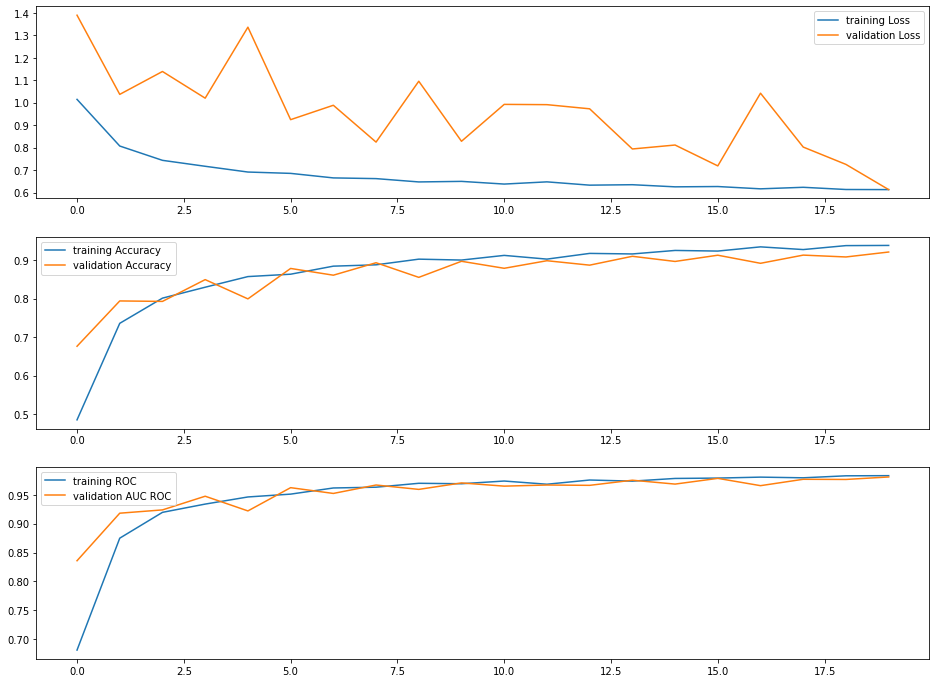

In [28]:
model = models.efficientnet_b3(True)
model.classifier = nn.Sequential(nn.Dropout(0.3),
                                 nn.Linear(in_features=1536, out_features=3, bias=True))
efficient_net_b3_results = doExperiment(model, epochs=20, learning_rate=1e-4, input_size=(3, 125, 125),
                                  model_name="efficientnet_b3_pretrained_AUC={}.pth")

### Plot ROC

100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


epoch loss : 0.6130572995509642 , acc : 0.9204, AUC : 0.9811739866666667


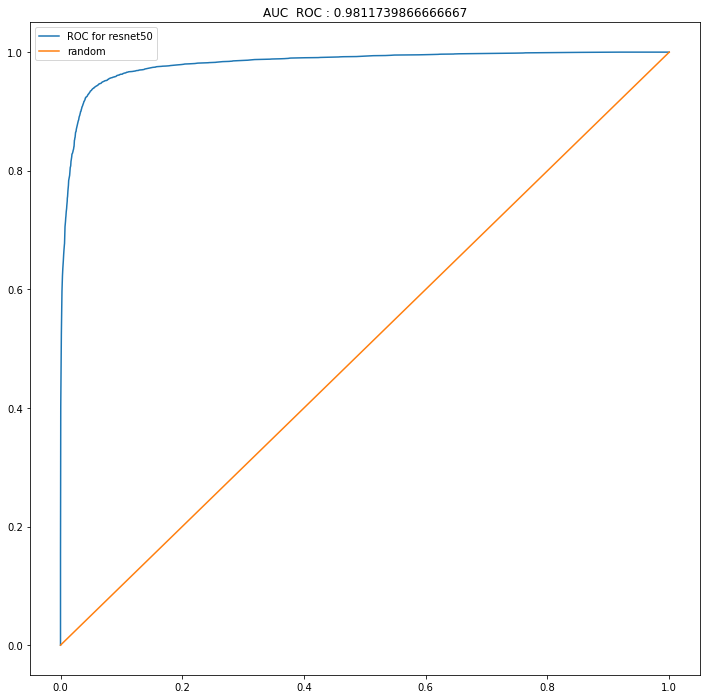

In [29]:
plot_ROC_curve_for_models(efficient_net_b3_results["best_model"], label="ROC for resnet50")

# EfficientNet b4

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 63, 63]           1,296
       BatchNorm2d-2           [-1, 48, 63, 63]              96
              SiLU-3           [-1, 48, 63, 63]               0
            Conv2d-4           [-1, 48, 63, 63]             432
       BatchNorm2d-5           [-1, 48, 63, 63]              96
              SiLU-6           [-1, 48, 63, 63]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12           [-1, 48, 63, 63]               0
           Conv2d-13           [-1, 24, 63, 63]           1,152
      BatchNorm2d-14           [-1, 24,

loss = 1.062635423162932, accuracy : 0.4198252856731415, AUC ROC 0.6078803001923719: 100%|██████████| 469/469 [04:21<00:00,  1.79it/s]


TRAINING ; Loss: 1.0621 Acc: 0.4206 AUC ROC : 0.6088 Time taken : 261.63


100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


VALIDATION : Loss: 1.7865 Acc: 0.5317 AUC ROC : 0.7237 Time taken : 19.16
New best, saving !
Epoch 1/19
----------


loss = 0.9014876595107458, accuracy : 0.6302083730697632, AUC ROC 0.8032344847966918: 100%|██████████| 469/469 [04:12<00:00,  1.86it/s]


TRAINING ; Loss: 0.9011 Acc: 0.6305 AUC ROC : 0.8035 Time taken : 252.67


100%|██████████| 118/118 [00:18<00:00,  6.45it/s]


VALIDATION : Loss: 1.7043 Acc: 0.6891 AUC ROC : 0.8562 Time taken : 18.3
New best, saving !
Epoch 2/19
----------


loss = 0.8212165944037899, accuracy : 0.7188844084739685, AUC ROC 0.8694776642423915: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.8212 Acc: 0.7189 AUC ROC : 0.8694 Time taken : 251.59


100%|██████████| 118/118 [00:18<00:00,  6.50it/s]


VALIDATION : Loss: 1.7873 Acc: 0.7152 AUC ROC : 0.8717 Time taken : 18.18
New best, saving !
Epoch 3/19
----------


loss = 0.7745728915737521, accuracy : 0.7693884372711182, AUC ROC 0.901851899507946: 100%|██████████| 469/469 [04:11<00:00,  1.86it/s]


TRAINING ; Loss: 0.7744 Acc: 0.7695 AUC ROC : 0.9019 Time taken : 252.07


100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


VALIDATION : Loss: 1.3408 Acc: 0.7872 AUC ROC : 0.9149 Time taken : 18.29
New best, saving !
Epoch 4/19
----------


loss = 0.7421865754230048, accuracy : 0.8040995001792908, AUC ROC 0.9214436601809218: 100%|██████████| 469/469 [04:11<00:00,  1.86it/s]


TRAINING ; Loss: 0.7425 Acc: 0.8038 AUC ROC : 0.9213 Time taken : 252.0


100%|██████████| 118/118 [00:18<00:00,  6.49it/s]


VALIDATION : Loss: 1.3092 Acc: 0.7737 AUC ROC : 0.9107 Time taken : 18.19
Epoch 5/19
----------


loss = 0.7255755425781332, accuracy : 0.820631742477417, AUC ROC 0.9306479617230853: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.7252 Acc: 0.8211 AUC ROC : 0.9309 Time taken : 251.56


100%|██████████| 118/118 [00:18<00:00,  6.51it/s]


VALIDATION : Loss: 1.5177 Acc: 0.8163 AUC ROC : 0.9330 Time taken : 18.14
New best, saving !
Epoch 6/19
----------


loss = 0.705742512338905, accuracy : 0.8416666984558105, AUC ROC 0.9408867753286488: 100%|██████████| 469/469 [04:11<00:00,  1.86it/s]


TRAINING ; Loss: 0.7057 Acc: 0.8418 AUC ROC : 0.9409 Time taken : 252.09


100%|██████████| 118/118 [00:18<00:00,  6.49it/s]


VALIDATION : Loss: 2.5948 Acc: 0.7993 AUC ROC : 0.9189 Time taken : 18.19
Epoch 7/19
----------


loss = 0.7022054286413295, accuracy : 0.8457661271095276, AUC ROC 0.9422887737107879: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.7022 Acc: 0.8458 AUC ROC : 0.9423 Time taken : 251.54


100%|██████████| 118/118 [00:18<00:00,  6.54it/s]


VALIDATION : Loss: 1.6003 Acc: 0.8331 AUC ROC : 0.9439 Time taken : 18.07
New best, saving !
Epoch 8/19
----------


loss = 0.6870815310426938, accuracy : 0.8608534932136536, AUC ROC 0.9496314854865489: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6872 Acc: 0.8607 AUC ROC : 0.9497 Time taken : 251.28


100%|██████████| 118/118 [00:18<00:00,  6.51it/s]


VALIDATION : Loss: 2.0744 Acc: 0.8075 AUC ROC : 0.9261 Time taken : 18.15
Epoch 9/19
----------


loss = 0.6915270764340636, accuracy : 0.8563843965530396, AUC ROC 0.9471895140340209: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6911 Acc: 0.8568 AUC ROC : 0.9473 Time taken : 251.61


100%|██████████| 118/118 [00:18<00:00,  6.47it/s]


VALIDATION : Loss: 1.8504 Acc: 0.8467 AUC ROC : 0.9464 Time taken : 18.26
New best, saving !
Epoch 10/19
----------


loss = 0.6739287089276057, accuracy : 0.8746976256370544, AUC ROC 0.9570262437312523: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6742 Acc: 0.8744 AUC ROC : 0.9569 Time taken : 251.39


100%|██████████| 118/118 [00:18<00:00,  6.50it/s]


VALIDATION : Loss: 1.5441 Acc: 0.8252 AUC ROC : 0.9421 Time taken : 18.17
Epoch 11/19
----------


loss = 0.6712077390763067, accuracy : 0.8778898119926453, AUC ROC 0.9581816542962684: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6714 Acc: 0.8778 AUC ROC : 0.9582 Time taken : 251.61


100%|██████████| 118/118 [00:18<00:00,  6.51it/s]


VALIDATION : Loss: 1.7414 Acc: 0.8575 AUC ROC : 0.9544 Time taken : 18.15
New best, saving !
Epoch 12/19
----------


loss = 0.6635176244602409, accuracy : 0.885618269443512, AUC ROC 0.9612149750641518: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6633 Acc: 0.8858 AUC ROC : 0.9613 Time taken : 251.21


100%|██████████| 118/118 [00:18<00:00,  6.52it/s]


VALIDATION : Loss: 3.0989 Acc: 0.8433 AUC ROC : 0.9356 Time taken : 18.1
Epoch 13/19
----------


loss = 0.6632292538560847, accuracy : 0.8859879374504089, AUC ROC 0.9604326842902489: 100%|██████████| 469/469 [04:11<00:00,  1.86it/s]


TRAINING ; Loss: 0.6634 Acc: 0.8858 AUC ROC : 0.9603 Time taken : 251.74


100%|██████████| 118/118 [00:18<00:00,  6.44it/s]


VALIDATION : Loss: 1.8009 Acc: 0.8700 AUC ROC : 0.9558 Time taken : 18.34
New best, saving !
Epoch 14/19
----------


loss = 0.6532511026628556, accuracy : 0.8968750238418579, AUC ROC 0.9639486812250534: 100%|██████████| 469/469 [04:11<00:00,  1.86it/s]


TRAINING ; Loss: 0.6535 Acc: 0.8966 AUC ROC : 0.9638 Time taken : 251.84


100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


VALIDATION : Loss: 2.5881 Acc: 0.8515 AUC ROC : 0.9455 Time taken : 18.3
Epoch 15/19
----------


loss = 0.6613169013812977, accuracy : 0.8880712389945984, AUC ROC 0.9608685727145557: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6611 Acc: 0.8882 AUC ROC : 0.9610 Time taken : 251.46


100%|██████████| 118/118 [00:18<00:00,  6.47it/s]


VALIDATION : Loss: 1.6151 Acc: 0.8735 AUC ROC : 0.9607 Time taken : 18.26
New best, saving !
Epoch 16/19
----------


loss = 0.6461812420557904, accuracy : 0.903494656085968, AUC ROC 0.9684446048417307: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]


TRAINING ; Loss: 0.6465 Acc: 0.9031 AUC ROC : 0.9682 Time taken : 251.48


100%|██████████| 118/118 [00:18<00:00,  6.50it/s]


VALIDATION : Loss: 2.5680 Acc: 0.8509 AUC ROC : 0.9458 Time taken : 18.17
Epoch 17/19
----------


loss = 0.6495454880499071, accuracy : 0.8997983932495117, AUC ROC 0.9664893599224621: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]


TRAINING ; Loss: 0.6495 Acc: 0.8999 AUC ROC : 0.9665 Time taken : 251.04


100%|██████████| 118/118 [00:18<00:00,  6.52it/s]


VALIDATION : Loss: 1.8293 Acc: 0.8768 AUC ROC : 0.9589 Time taken : 18.11
Epoch 18/19
----------


loss = 0.6401517943669391, accuracy : 0.909375011920929, AUC ROC 0.9708824439689678: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]


TRAINING ; Loss: 0.6404 Acc: 0.9091 AUC ROC : 0.9708 Time taken : 251.17


100%|██████████| 118/118 [00:18<00:00,  6.52it/s]


VALIDATION : Loss: 1.6766 Acc: 0.8609 AUC ROC : 0.9537 Time taken : 18.11
Epoch 19/19
----------


loss = 0.642535703156584, accuracy : 0.907056450843811, AUC ROC 0.9700712656063845: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]


TRAINING ; Loss: 0.6425 Acc: 0.9070 AUC ROC : 0.9701 Time taken : 251.11


100%|██████████| 118/118 [00:17<00:00,  6.56it/s]


VALIDATION : Loss: 1.7403 Acc: 0.8812 AUC ROC : 0.9638 Time taken : 17.99
New best, saving !
Training complete in 90m 11s


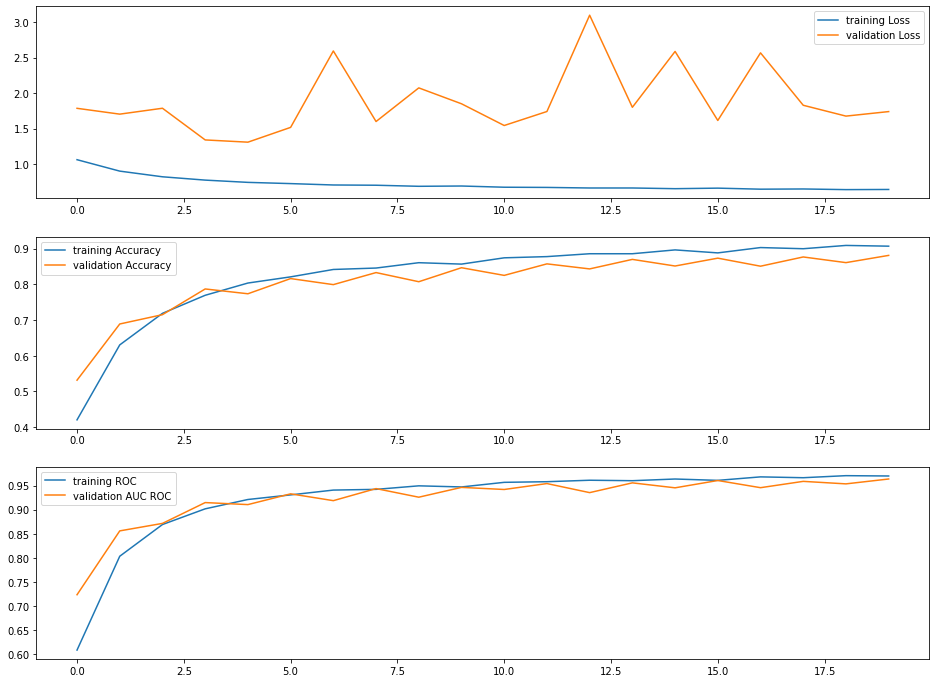

In [15]:
model = models.efficientnet_b4(True)
model.classifier = nn.Sequential(nn.Dropout(0.3),
                                 nn.Linear(in_features=1792, out_features=3, bias=True))
efficient_net_b4_results = doExperiment(model, epochs=20, learning_rate=1e-4, input_size=(3, 125, 125),
                                        model_name="efficientnet4_pretrained_AUC={}.pth")

## Plot ROC 

100%|██████████| 118/118 [00:18<00:00,  6.44it/s]


epoch loss : 1.7403136461893718 , acc : 0.8812000000000001, AUC : 0.9638466133333333


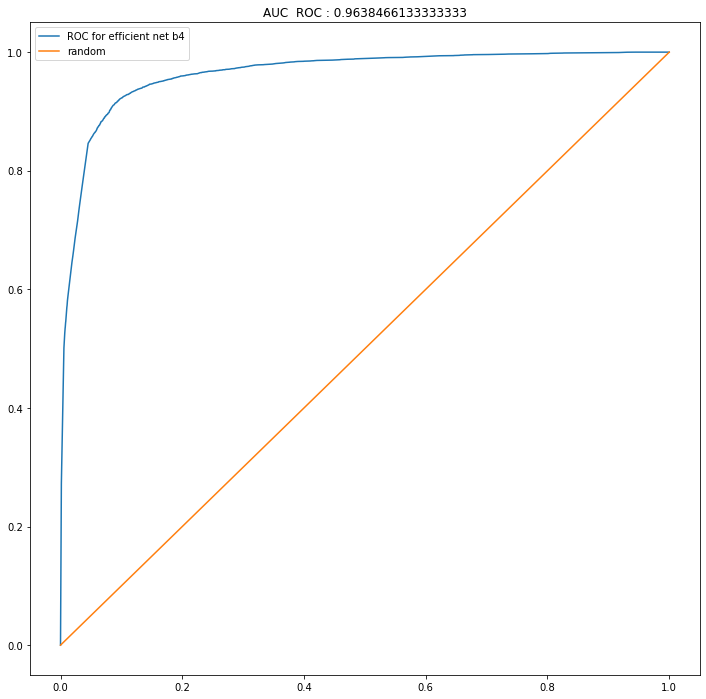

In [16]:
plot_ROC_curve_for_models(efficient_net_b4_results["best_model"], label="ROC for efficient net b4")